In [1]:
from typing import Dict, Callable, Collection, List, Set
import os
from dataclasses import dataclass, field
from collections import defaultdict
import numpy as np
import itertools
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import functools

In [2]:
plt.style.use('seaborn')

In [3]:
%run common.ipynb

In [4]:
@dataclass
class Edge(object):
    node: 'Node'
    relation: str

        
@dataclass
class Node(object):
    entity_name: str
    input_edges: List[Edge] = field(default_factory=list)
    output_edges: List[Edge] = field(default_factory=list)

        
class FingerprintFactory(object):
    
    def __init__(self, dataset_relations: Collection[str]):
        self.relations_indexes = dict(zip(
            dataset_relations, range(len(dataset_relations))
        ))

    def _get_edges_at_distance(
        self,
        nodes_to_process: List[Node],
        node_edges_func: Callable[[Node], List[Edge]],
        visited_entities: Set[str],
        distance: int,        
    ) -> List[Edge]:
        if distance <= 1:
            return list(itertools.chain(*[
                node_edges_func(node) for node in nodes_to_process
            ]))
        next_nodes = []
        for node in nodes_to_process:
            for edge in node_edges_func(node):
                if edge.node.entity_name in visited_entities:
                    continue
                visited_entities.add(edge.node.entity_name)
                next_nodes.append(edge.node)
        return self._get_edges_at_distance(
            next_nodes, node_edges_func, visited_entities, distance - 1
        )

    def _get_fingerprint_of_edges(self, edges: List[Edge]) -> np.ndarray:
        fingerprint = np.zeros(len(self.relations_indexes), dtype=np.float32)
        for edge in edges:
            relation_index = self.relations_indexes[edge.relation]
            fingerprint[relation_index] += 1.0
        return fingerprint / np.maximum(np.sum(fingerprint), 1.0)
    
    def get_fingerprint_of_node_edges(
        self,
        node: Node,
        node_edges_func: Callable[[Node], List[Edge]],        
        neighbors_distance: int,
    ) -> np.ndarray:
        nodes_to_process = [node]
        visited_entities = {node.entity_name}
        edges = self._get_edges_at_distance(
            nodes_to_process,
            node_edges_func,
            visited_entities,
            neighbors_distance,            
        )
        return self._get_fingerprint_of_edges(edges)        

    def get_input_fingerprint(
        self, node: Node, neighbors_distance: int
    ) -> np.ndarray:
        node_edges_func = lambda x: x.input_edges
        return self._get_fingerprint_of_node_edges(
            node, node_edges_func, neighbors_distance
        )

    def get_output_fingerprint(
        self, node: Node, neighbors_distance: int
    ) -> np.ndarray:
        node_edges_func = lambda x: x.output_edges
        return self._get_fingerprint_of_node_edges(
            node, node_edges_func, neighbors_distance
        )

In [5]:
def construct_graph(dataset_path, samples_path):
    entities = load_entities_of_dataset(dataset_path)
    graph = {}
    for entity in entities:
        graph[entity] = Node(entity_name=entity)
    samples = load_matching_samples(samples_path)        
    for head_entity, relation, tail_entity in samples:
        output_edge = Edge(graph[tail_entity], relation)
        graph[head_entity].output_edges.append(output_edge)
        input_edge = Edge(graph[head_entity], relation)
        graph[tail_entity].input_edges.append(input_edge)
    return graph


def plot_relations_count_distribution(
    counts, bin_size, relations_count_threshold, title
):
    clipped_counts = [
        np.clip(value, 0, relations_count_threshold + 1)
        for value in counts
    ]
    bins = np.array([bin_size * i for i in range(12)])
    plt.figure(figsize=(12, 8))
    plt.title(title)
    plt.xlabel("Number of edges for a node")
    plt.ylabel("Nodes count")    
    plt.hist(clipped_counts, bins=bins, rwidth=0.9)    
    labels = [
        f"[{bins[i - 1]}-{bins[i]})" for i in range(1, len(bins) - 1)
    ]  
    labels.append(f"{bins[-2]}+")
    plt.xticks(bins[:-1] + bin_size / 2.0, labels)


def plot_relations_counts(graph, bin_size, relations_count_threshold):
    output_counts = [len(node.output_edges) for node in graph.values()]            
    plot_relations_count_distribution(
        output_counts,
        bin_size,
        relations_count_threshold,
        title="A distribution of output edges counts"
    )    
    input_counts = [len(node.input_edges) for node in graph.values()]    
    plot_relations_count_distribution(
        input_counts,
        bin_size,
        relations_count_threshold,        
        title="A distribution of input edges counts"
    )


def analyze_nodes_fingerprints(
    entity_fingerprints, clusters_count, bins_count, edges_type
):
    fingerprints = list(entity_fingerprints.values())
    data_matrix = np.vstack(fingerprints)
    k_means = KMeans(n_clusters=clusters_count, max_iter=50000)
    cluster_indexes = k_means.fit_predict(data_matrix)
    samples_counts, filled_features_counts = [], []
    for cluster_index in sorted(set(cluster_indexes)):
        cluster_samples = data_matrix[cluster_indexes == cluster_index]
        filled_features_count = np.sum(np.any(cluster_samples > 1e-5, axis=0))
        samples_counts.append(len(cluster_samples))
        filled_features_counts.append(filled_features_count)
    plt.figure(figsize=(12, 8))
    plt.title(
        "The number of samples in clusters vs. the number of non-trivial "
        f"features for clusters ({edges_type}, {clusters_count} clusters)"
    )
    plt.xlabel("Samples count")
    plt.ylabel("The number of non-trivial features")
    plt.scatter(samples_counts, filled_features_counts)


def get_graph_fingerprints(
    dataset_path, graph, node_edges_func, neighbors_distance
) -> Dict[str, np.ndarray]:
    relations = load_relations_of_dataset(dataset_path)
    fingerprint_factory = FingerprintFactory(relations)    
    fingerprint_func = functools.partial(
        fingerprint_factory.get_fingerprint_of_node_edges,
        node_edges_func=node_edges_func,
        neighbors_distance=neighbors_distance,
    )
    return {
        entity_name: fingerprint_func(node)
        for entity_name, node in graph.items()
    }


def analyze_graph_fingerprints(
    dataset_path, graph, clusters_count, clusters_bins_count
):
    for neighbors_distance in [1, 2]:
        output_fingerprints = get_graph_fingerprints(
            dataset_path,
            graph,
            node_edges_func=lambda node: node.output_edges,
            neighbors_distance=neighbors_distance,
        )
        analyze_nodes_fingerprints(
            output_fingerprints,
            clusters_count,
            clusters_bins_count,
            edges_type=f"output edges of distance {neighbors_distance}",
        )
    for neighbors_distance in [1, 2]:
        input_fingerprints = get_graph_fingerprints(
            dataset_path,
            graph,
            node_edges_func=lambda node: node.input_edges,
            neighbors_distance=neighbors_distance,            
        )    
        analyze_nodes_fingerprints(
            input_fingerprints,
            clusters_count,
            clusters_bins_count,
            edges_type=f"input edges of distance {neighbors_distance}",
        )


def explore_dataset_fingerprints(
    dataset_path,
    relations_bin_size,
    relations_count_threshold,
    clusters_count,
    clusters_bins_count,
):
    training_samples_path = get_training_samples_path(dataset_path)
    graph = construct_graph(dataset_path, training_samples_path)
    plot_relations_counts(
        graph, relations_bin_size, relations_count_threshold
    )
    analyze_graph_fingerprints(
        dataset_path, graph, clusters_count, clusters_bins_count
    )

## WN18RR

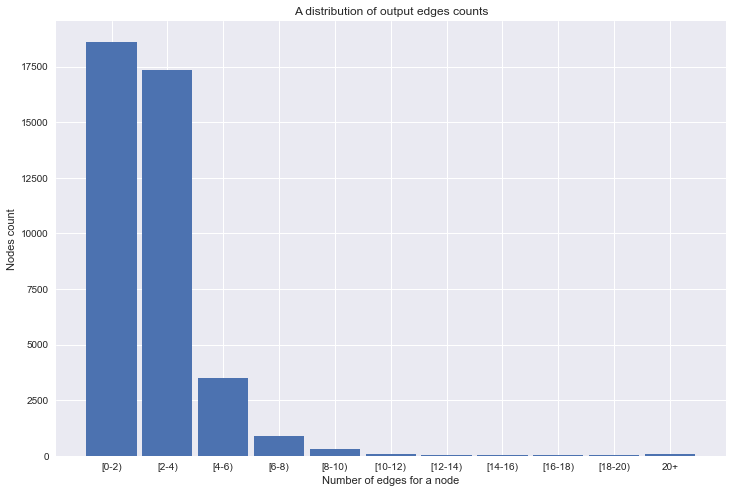

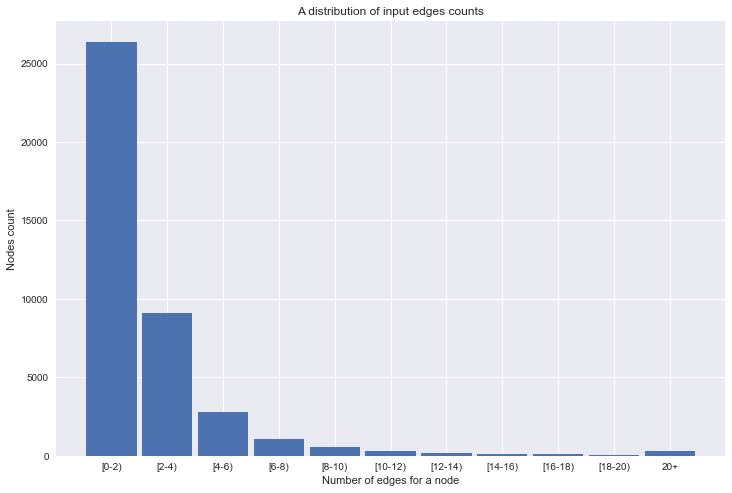

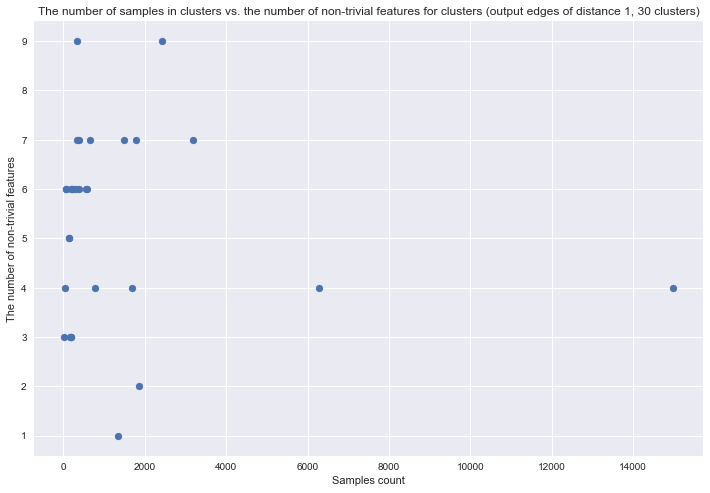

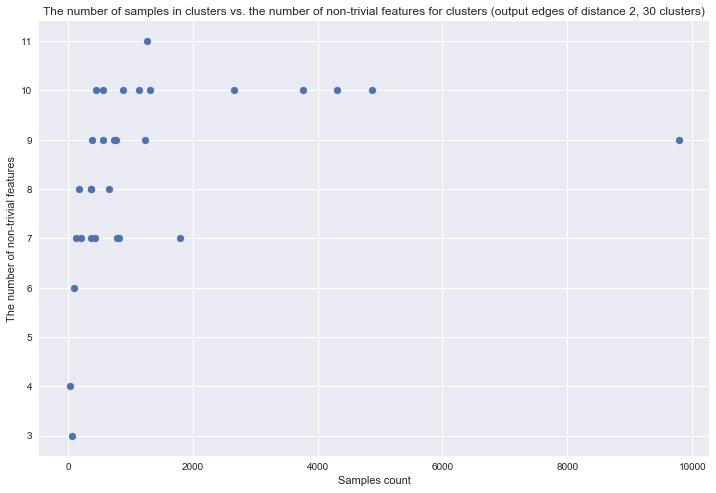

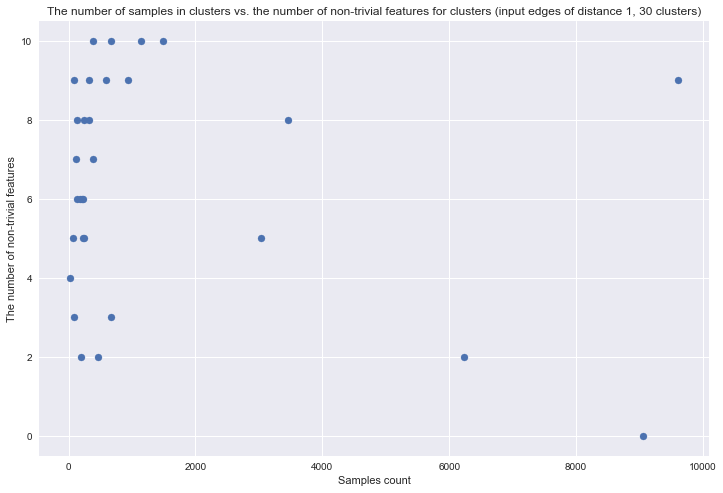

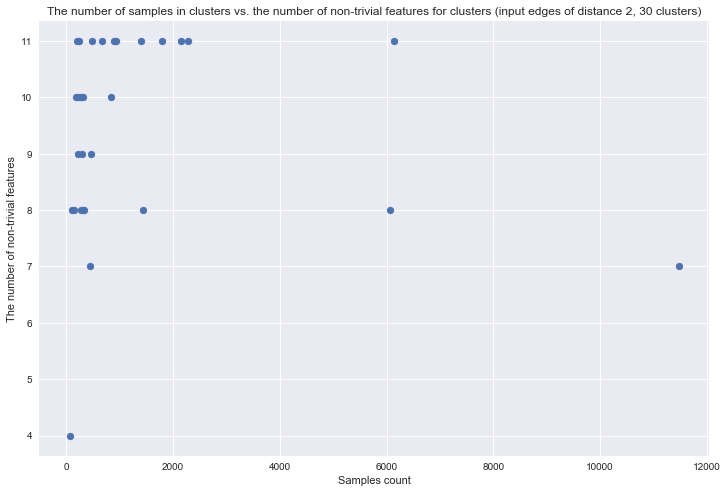

In [6]:
explore_dataset_fingerprints(
    WN18RR_DATASET_PATH,
    relations_bin_size=2,
    relations_count_threshold=21,
    clusters_count=30,
    clusters_bins_count=5,
)

## FB15K

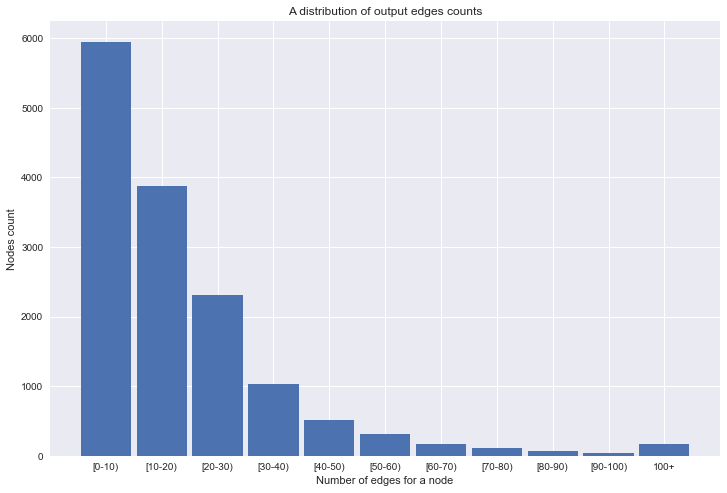

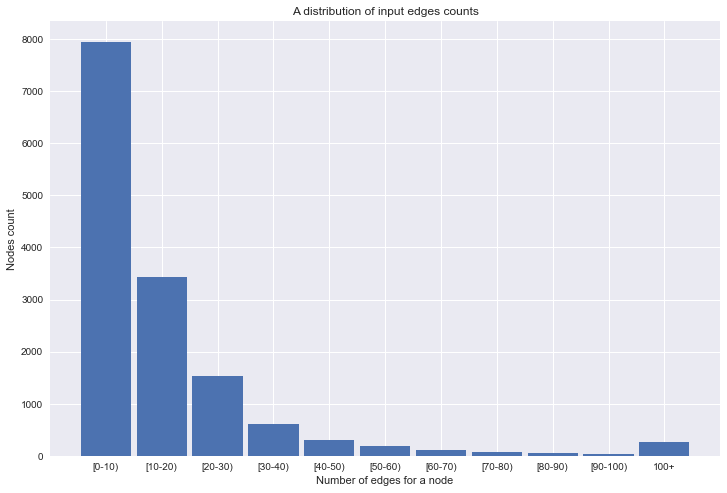

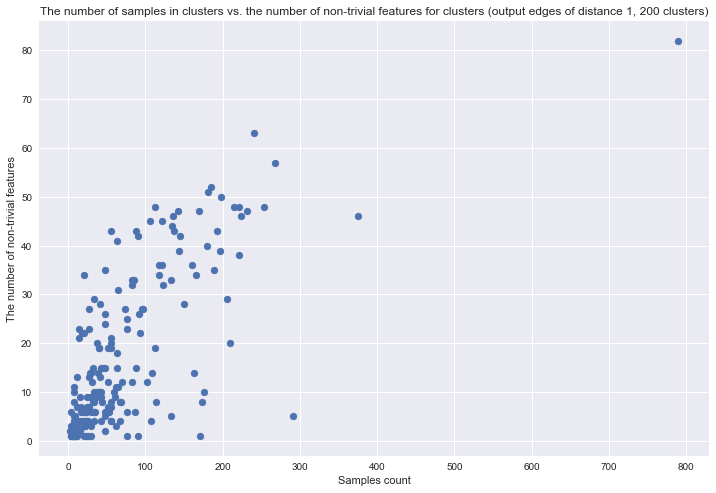

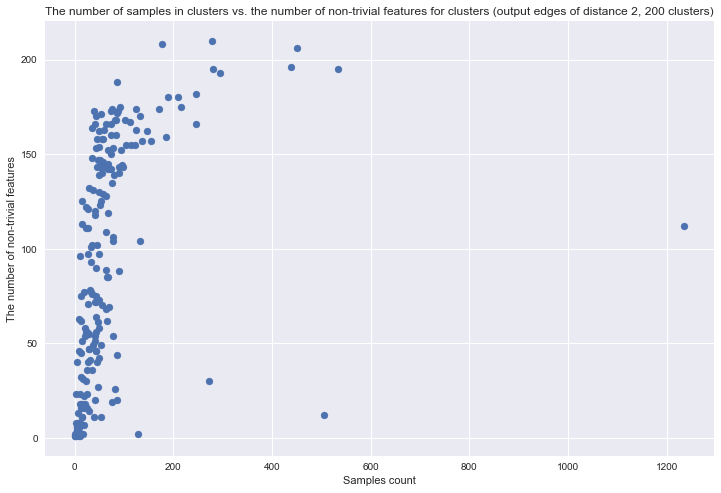

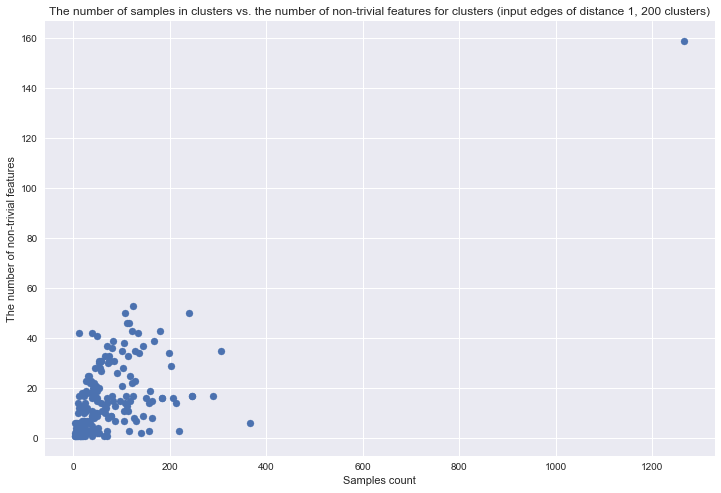

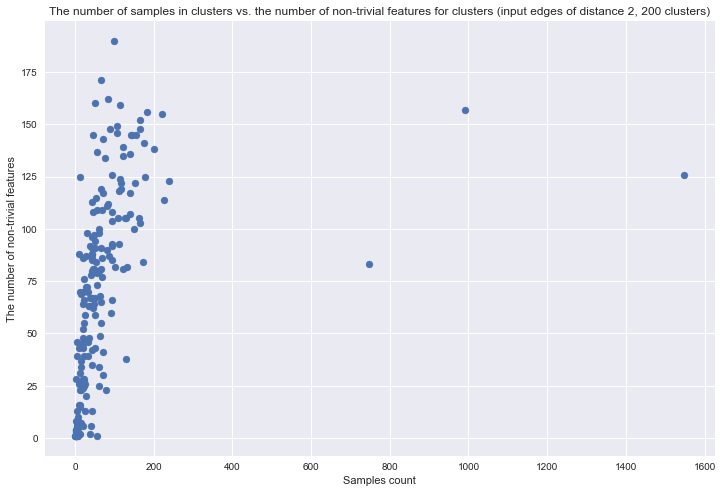

In [7]:
explore_dataset_fingerprints(
    FB15K_DATASET_PATH,
    relations_bin_size=10,
    relations_count_threshold=101,
    clusters_count=200,
    clusters_bins_count=30,
)